In [ ]:
!kaggle datasets download -d samuelcortinhas/cats-and-dogs-image-classification

In [ ]:
import zipfile
import os

# Unzip the downloaded dataset using Python
with zipfile.ZipFile('cats-and-dogs-image-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('data')  # Specify your extraction path

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

e:\SYLLABUS\CAPSTONE\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Set parameters
import torchvision.models as models
batch_size = 32
num_epochs = 20
learning_rate = 0.001

# Define transformations for the training and validation datasets
transform = transforms.Compose([
    transforms.Resize((150, 150)),  # Resize images to 150x150 pixels
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize images
])

# Load datasets from directories (update paths accordingly)
train_dataset = torchvision.datasets.ImageFolder(
    root='data/train', transform=transform)  # Update with actual path
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size, shuffle=True)

validation_dataset = torchvision.datasets.ImageFolder(
    root='data/test', transform=transform)  # Update with actual path
validation_loader = DataLoader(
    dataset=validation_dataset, batch_size=batch_size, shuffle=False)

# Define the CNN architecture


class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Load a pre-trained ResNet model
        self.base_model = models.resnet18(pretrained=True)
        # Replace final layer for binary classification
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, 1)
        self.dropout = nn.Dropout(0.5)  # Add dropout layer

    def forward(self, x):
        x = self.base_model(x)
        x = torch.sigmoid(x)  # Sigmoid for binary classification
        return x


# Initialize model, loss function and optimizer
model = CNNModel()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

e:\SYLLABUS\CAPSTONE\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
e:\SYLLABUS\CAPSTONE\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)

        # Calculate loss and backpropagate
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(
        f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# Save the model
torch.save(model.state_dict(), 'cats_and_dogs_model.pth')
print("Model saved as 'cats_and_dogs_model.pth'")

Epoch [1/20], Loss: 0.4135
Epoch [2/20], Loss: 0.2344
Epoch [3/20], Loss: 0.1384
Epoch [4/20], Loss: 0.0855
Epoch [5/20], Loss: 0.0657
Epoch [6/20], Loss: 0.0740
Epoch [7/20], Loss: 0.1092
Epoch [8/20], Loss: 0.0991
Epoch [9/20], Loss: 0.0523
Epoch [10/20], Loss: 0.0292
Epoch [11/20], Loss: 0.0325
Epoch [12/20], Loss: 0.0418
Epoch [13/20], Loss: 0.0719
Epoch [14/20], Loss: 0.0471
Epoch [15/20], Loss: 0.0151
Epoch [16/20], Loss: 0.0277
Epoch [17/20], Loss: 0.0438
Epoch [18/20], Loss: 0.0330
Epoch [19/20], Loss: 0.0156
Epoch [20/20], Loss: 0.0070
Model saved as 'cats_and_dogs_model.pth'


In [ ]:
# Testing the model's accuracy on the validation dataset
def test_model_accuracy(model, validation_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in validation_loader:
            outputs = model(images)
            # Convert probabilities to binary predictions (0 or 1)
            predicted = (outputs.squeeze() > 0.5).float()
            total += labels.size(0)  # Total number of samples
            # Count correct predictions
            correct += (predicted == labels.float()).sum().item()

    accuracy = correct / total * 100  # Calculate accuracy as a percentage
    return accuracy


# Call the function to test accuracy
accuracy = test_model_accuracy(model, validation_loader)
print(f'Validation Accuracy: {accuracy:.2f}%')

Validation Accuracy: 82.86%


# Test on One Image

In [ ]:
model_loaded = CNNModel()
model_loaded.load_state_dict(torch.load('cats_and_dogs_model.pth'))
model_loaded.eval()
# Update with actual image path
image_path = r'result_original.png'
image = Image.open(image_path).convert('RGB')  # Ensure image is in RGB format
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Apply transformations
image = transform(image)

# Add a batch dimension (since PyTorch models expect a batch of images)
image = image.unsqueeze(0)  # Shape: [1, 3, 150, 150]

# Move the image to GPU if available (optional)
if torch.cuda.is_available():
    model = model_loaded.to(device)
    image = image.to(device)

# Make prediction
with torch.no_grad():  # No need to compute gradients for testing
    output = model(image)
    # For binary classification, round to get class label
    prediction = torch.round(output)

print(f'Predicted class: {output}')  # Output the predicted class

cuda
Predicted class: tensor([[1.6929e-05]], device='cuda:0')


In [ ]:
class Generator(nn.Module):
    def __init__(self, image_channels=3):
        super(Generator, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # Downsampling
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )

        # Noise generator
        self.noise_generator = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, image_channels, 3, padding=1),
            nn.Tanh()  # Output small perturbations
        )

        # Upsampling layer to match original input size
        self.upsample = nn.Upsample(
            size=(150, 150), mode='bilinear', align_corners=True)

    def forward(self, x):
        features = self.encoder(x)
        noise = self.noise_generator(features)

        # Upsample noise to match original input size (150x150)
        noise_upsampled = self.upsample(noise)

        return x + noise_upsampled  # Now both tensors should have matching

# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torchvision.transforms as transforms
# from torch.utils.data import Dataset, DataLoader
# import numpy as np
# from PIL import Image



# # Generator Network


# class Generator(nn.Module):
#     def __init__(self, image_channels=3):
#         super(Generator, self).__init__()

#         # Encoder
#         # self.encoder = nn.Sequential(
#         #     nn.Conv2d(image_channels, 64, 3, padding=1),
#         #     nn.ReLU(),
#         #     nn.Conv2d(64, 128, 3, padding=1),
#         #     nn.ReLU(),
#         # )
#         self.encoder = nn.Sequential(
#             nn.Conv2d(image_channels, 64, 3, padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2),  # Downsampling
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             # nn.BatchNorm2d(128),
#             nn.ReLU()
#             # nn.MaxPool2d(kernel_size=2),  # Further downsampling
#         )

#         # Noise generator
#         self.noise_generator = nn.Sequential(
#             nn.Conv2d(128, 128, 3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(128, 64, 3, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(64, image_channels, 3, padding=1),
#             nn.Tanh()  # Output small perturbations
#         )

#     def forward(self, x):
#         features = self.encoder(x)
#         noise = self.noise_generator(features)
#         return x + noise  # Scale factor 0.1 to keep perturbations small

# Custom Dataset




class AdversarialDataset(Dataset):


    def __init__(self, image_paths, transform=None):


        self.image_paths = image_paths
        self.transform = transform



    def __len__(self):


        return len(self.image_paths)



    def __getitem__(self, idx):


        image = Image.open(self.image_paths[idx]).convert('RGB')


        if self.transform:
            image = self.transform(image)

        return image
    



NameError: name 'nn' is not defined

In [ ]:
# Example usage:
def setup_dataset():
    # Define your image paths
    data_dir = "path/to/your/dataset"  # Main directory containing images

    # Collect all image paths
    image_paths = []

    # Option 1: If images are in a flat directory
    for img_name in os.listdir(data_dir):
        if img_name.endswith(('.jpg', '.jpeg', '.png')):
            full_path = os.path.join(data_dir, img_name)
            image_paths.append(full_path)

    # Option 2: If images are in class subdirectories (cats/dogs)
    """
    for class_name in ['cats', 'dogs']:
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            if img_name.endswith(('.jpg', '.jpeg', '.png')):
                full_path = os.path.join(class_dir, img_name)
                image_paths.append(full_path)
    """

    # Define transform
    transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Create dataset and dataloader
    dataset = AdversarialDataset(image_paths=image_paths, transform=transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    return dataloader


data_dir = r"data\train\cats"
image_paths = []
for root, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
            full_path = os.path.join(root, file)
            image_paths.append(full_path)

# 3. Create transform
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 4. Create dataset and dataloader
train_dataset = AdversarialDataset(image_paths=image_paths, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"Total images loaded: {len(train_dataset)}")
# return train_loader

Total images loaded: 279


In [ ]:
def train_adversarial_gan(generator, classifier, train_loader, num_epochs=20, device='cuda'):
    # Move models to device
    generator = generator.to(device)
    classifier = classifier.to(device)
    classifier.eval()  # Put classifier in eval mode since it's pre-trained

    # Loss functions
    adversarial_criterion = nn.BCELoss()
    l2_criterion = nn.MSELoss()

    # Optimizer with specified learning rate
    g_optimizer = optim.Adam(generator.parameters(),
                             lr=0.001, betas=(0.5, 0.999))

    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, real_images in enumerate(train_loader):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            # Train Generator
            g_optimizer.zero_grad()

            adversarial_images = generator(real_images)

            # Calculate classifier predictions
            original_preds = classifier(real_images)
            adversarial_preds = classifier(adversarial_images)
            
            # Generator wants to flip the classification
            target_preds = 1 - original_preds

            # Calculate losses
            adversarial_loss = adversarial_criterion(adversarial_preds, target_preds)

            # L2 loss to minimize perturbation
            perturbation_loss = l2_criterion(adversarial_images, real_images)

            # Combined loss
            g_loss = adversarial_loss + 0.1 * perturbation_loss

            g_loss.backward()
            g_optimizer.step()

            total_loss += g_loss.item()

            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch}/{num_epochs}] Batch [{batch_idx}/{len(train_loader)}] '
                      f'Loss: {g_loss.item():.4f} '
                      f'Adv Loss: {adversarial_loss.item():.4f} '
                      f'Pert Loss: {perturbation_loss.item():.4f}')

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch [{epoch}/{num_epochs}] Average Loss: {avg_loss:.4f}')

# Function to test the generator


def test_generator(generator, classifier, image_path, device='cuda'):
    # Use the same transform as training
    transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Generate adversarial image
    generator.eval()
    with torch.no_grad():
        adversarial_image = generator(image_tensor)

        # Get predictions
        original_pred = classifier(image_tensor)
        adversarial_pred = classifier(adversarial_image)

        print(f'Original prediction: {original_pred.item():.4f}')
        print(f'Adversarial prediction: {adversarial_pred.item():.4f}')

        # Calculate perturbation magnitude
        perturbation = adversarial_image - image_tensor
        perturbation_magnitude = torch.norm(perturbation)
        print(f'Perturbation magnitude: {perturbation_magnitude.item():.4f}')

    return image_tensor, adversarial_image

# Usage example


def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize models
    generator = Generator()
    classifier = CNNModel()  # Your pre-trained classifier

    # Load pre-trained classifier weights
    classifier.load_state_dict(torch.load('cats_and_dogs_model.pth'))

    train_adversarial_gan(generator, classifier,
                          train_loader, num_epochs=3, device=device)
    _,image = test_generator(generator,classifier,"data/train/cats/cat_605.jpg",device)

    torch.save(generator.state_dict(), 'adversarial_generator.pth')

main()

Epoch [0/3] Batch [0/9] Loss: 9.7021 Adv Loss: 9.7021 Pert Loss: 0.0008
Epoch [0/3] Average Loss: 5.1409
Epoch [1/3] Batch [0/9] Loss: 1.8490 Adv Loss: 1.7957 Pert Loss: 0.5328
Epoch [1/3] Average Loss: 1.0784
Epoch [2/3] Batch [0/9] Loss: 0.9523 Adv Loss: 0.8925 Pert Loss: 0.5972
Epoch [2/3] Average Loss: 0.6184
Original prediction: 0.0000
Adversarial prediction: 0.9991
Perturbation magnitude: 151.7880



Final processed image shape: torch.Size([1, 3, 150, 150])
Final processed image range: -0.9843137264251709 to 1.0


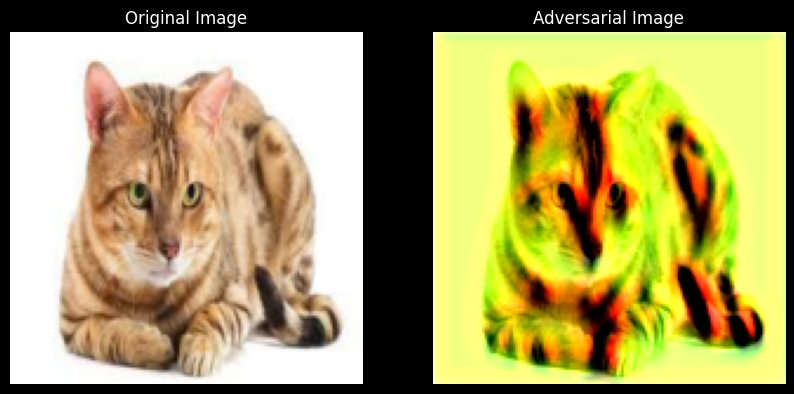

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt  # For visualization


def load_and_process_image(image_path):
    """
    Load and process a single image for the generator
    """
    # 1. Load image using PIL
    image = Image.open(image_path).convert('RGB')

    # 2. Define the same transforms we used in training
    transform = transforms.Compose([
        # Resize to match generator's expected size
        transforms.Resize((150, 150)),
        transforms.ToTensor(),          # Convert to tensor and scale to [0,1]
        # Normalize to [-1,1]
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # 3. Apply transformations
    image_tensor = transform(image)

    # 4. Add batch dimension
    image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension

    return image_tensor


def visualize_stages(image_path):
    """
    Visualize the image at different stages of processing
    """
    # 1. Original image
    original_image = Image.open(image_path).convert('RGB')

    # 2. After resize
    resize_transform = transforms.Resize((150, 150))
    resized_image = resize_transform(original_image)

    # 3. After to tensor (need to convert back to PIL for visualization)
    tensor_transform = transforms.ToTensor()
    tensor_image = tensor_transform(resized_image)

    # 4. After normalization
    normalize_transform = transforms.Normalize(
        (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    normalized_image = normalize_transform(tensor_image)

    # Print shapes and value ranges
    print("Tensor image shape:", tensor_image.shape)
    print("Tensor image range:", tensor_image.min().item(),
          "to", tensor_image.max().item())
    print("Normalized image range:", normalized_image.min().item(),
          "to", normalized_image.max().item())

    return normalized_image

# Example usage


def main():
    # Path to your image
    image_path = r'data\train\cats\cat_21.jpg'

    # Load and process image
    processed_image = load_and_process_image(image_path)
    print("\nFinal processed image shape:", processed_image.shape)
    print("Final processed image range:", processed_image.min().item(),
          "to", processed_image.max().item())

    # Use with generator
    generator = Generator()  # Your generator model
     # Set to evaluation mode
    generator.load_state_dict(torch.load("adversarial_generator.pth"))
    generator.eval()
    with torch.no_grad():
        adversarial_image = generator(processed_image)

    return processed_image, adversarial_image

# Function to save and visualize results
processed_image,adversarial_image = main()

def save_and_visualize(original_tensor, adversarial_tensor, save_path):
    """
    Convert tensors back to images and save/display them
    """
    # Denormalize
    def denormalize(tensor):
        tensor = tensor.squeeze(0)  # Remove batch dimension
        tensor = tensor * 0.5 + 0.5  # Denormalize
        return tensor.clamp(0, 1)  # Clamp values to [0,1]

    # Convert to images
    original_img = transforms.ToPILImage()(denormalize(original_tensor))
    adversarial_img = transforms.ToPILImage()(denormalize(adversarial_tensor))

    # Save images
    original_img.save(f"{save_path}_original.png")
    adversarial_img.save(f"{save_path}_adversarial.png")

    # Display images
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(adversarial_img)
    plt.title("Adversarial Image")
    plt.axis('off')
    plt.show()


# # Complete example usage
# if __name__ == "__main__save_and_visualize":
#     # 1. Load and process image
#     image_path = 'data/test/cats/cat_1.jpg'
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#     # 2. Load image
#     processed_image = load_and_process_image(image_path)
#     processed_image = processed_image.to(device)

#     # 3. Load generator
#     generator = Generator()
#     # generator.load_state_dict(torch.load('generator_weights.pth'))
#     generator = generator.to(device)
#     generator.eval()

#     # 4. Generate adversarial image
#     with torch.no_grad():
#         adversarial_image = generator(processed_image)

#     # 5. Save and visualize results
save_and_visualize(processed_image, adversarial_image, 'result')